In [1]:
import findspark 
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("random_forest_explain").config("spark.sql.execution.arrow.enabled", "true").enableHiveSupport().getOrCreate()

In [3]:
import re
from typing import List
from itertools import chain
from pyspark.ml import Model
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer, OneHotEncoder

from transparency.spark.ohe.decoder import OneHotDecoder
from transparency.spark.prediction.explainer.tree import EnsembleTreeExplainTransformer

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def get_ensemble_pipeline_stages(categorical_columns, continuous_columns, label_column, ensemble_type,
                                 classification=False
                                 ) -> List:
    encoders = []
    for c in categorical_columns:
        indexer = StringIndexer(inputCol=c, outputCol=f"{c}_IDX")
        encoders.append(indexer)
        encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=f"{c}_OHE", dropLast=False)
        encoders.append(encoder)

    features_column = f"features_{label_column}"
    prediction_column = f"prediction_{label_column}"

    assembler = VectorAssembler(inputCols=[f"{c}_OHE" for c in categorical_columns] + continuous_columns,
                                outputCol=features_column)

  
    if classification:
        _model = RandomForestClassifier(labelCol=label_column, featuresCol=features_column, predictionCol=prediction_column)
    else:  
        _model = RandomForestRegressor(labelCol=label_column, featuresCol=features_column, predictionCol=prediction_column)
    
    stages: List = encoders + [assembler, _model]

    return stages

In [5]:
def get_feature_importance(spark_session: SparkSession, model: Model, prediction_df: DataFrame,
                           feature_column: str, ) -> DataFrame:
    ml_attributes = prediction_df.schema[feature_column].metadata["ml_attr"]["attrs"].values()
    attrs = sorted((attr["idx"], attr["name"]) for attr in (chain(*ml_attributes)))
    feature_importance = [
        (idx, re.sub('[^0-9a-zA-Z]+', '_', name), name, float(model.featureImportances[idx]))
        for
        idx, name
        in attrs]
    feature_importance.sort(key=lambda x: x[3], reverse=True)
    feature_importance_df: DataFrame = spark_session.createDataFrame(feature_importance).toDF("Feature_Index",
                                                                                              "Feature",
                                                                                              "Original_Feature",
                                                                                              "Importance")

    return feature_importance_df

In [6]:
def get_ensemble_explain_stages(predictions_view: str, features_importance_view: str, label_column: str,
                                rf_model_path: str, ensemble_type: str, classification=False) -> List:
    stages = [
        OneHotDecoder(oheSuffix="_OHE", idxSuffix="_IDX", unknownSuffix="Unknown"),
        SQLTransformer(statement=f"CREATE OR REPLACE TEMPORARY VIEW {predictions_view} AS SELECT * from __THIS__"),
        EnsembleTreeExplainTransformer(predictionView=predictions_view, featureImportanceView=features_importance_view,
                                       modelPath=rf_model_path, label=label_column,
                                       dropPathColumn=True, isClassification=classification, ensembleType=ensemble_type)
    ]
    return stages

# Random Forest Regression 
- The example below is using **boston dataset** for preciting the **median home prices** for occupied homes.
- The example is stricitly used for **demonstrating** the uagae of `EnsembleTreeExplainTransformer`.

In [7]:
boston_csv = '/work/tests/data/regression/dataset_boston.csv'
boston_df: DataFrame = spark.read.option("header", True).option("inferSchema", True).csv(boston_csv)

In [8]:
label_column = 'medv'
features_column = f"features_{label_column}"
prediction_column = f"prediction_{label_column}"

contrib_column = f"prediction_{label_column}_contrib"
contrib_column_sum = f"{contrib_column}_sum"
contrib_column_intercept = f"{contrib_column}_intercept"

features_importance_view = f"features_importance_{label_column}_view"
predictions_view = f"predictions_{label_column}_view"

In [9]:
categorical_columns=[]
continuous_columns = [x for x in boston_df.columns if x not in ['id', label_column]]

In [15]:
stages = get_ensemble_pipeline_stages([], continuous_columns + categorical_columns, label_column, ensemble_type="rf",classification=False)

In [16]:
import uuid
pipeline = Pipeline(stages=stages)
pipeline_model: PipelineModel = pipeline.fit(boston_df)
rf_model = pipeline_model.stages[-1]
string_id = uuid.uuid4()
rf_model_path: str = f"/tmp/{string_id}"
rf_model.write().save(rf_model_path)

In [17]:
prediction_df = pipeline_model.transform(boston_df)
prediction_df.createOrReplaceTempView(predictions_view)

In [18]:
features_importance_df = get_feature_importance(spark, rf_model, prediction_df, features_column)
features_importance_df.createOrReplaceTempView(features_importance_view)

In [20]:
explain_stages = get_ensemble_explain_stages(predictions_view, features_importance_view, label_column, rf_model_path,ensemble_type="rf",classification=False)
explain_pipeline = Pipeline(stages=explain_stages)
explain_df = explain_pipeline.fit(prediction_df).transform(prediction_df)

In [21]:
feature_index_meta = features_importance_df.select("Feature_Index", "Feature").orderBy("Feature_Index").rdd.collectAsMap()

In [22]:
expressions = []
for key,value in feature_index_meta.items():
    expressions.append(f"AVG({contrib_column}[{key}]) as {value}")

contributions = explain_df.selectExpr(expressions).collect()[0].asDict()

In [23]:
plot_contrib_df = pd.DataFrame.from_dict(contributions,orient='index',columns=['Contributions'])
plot_contrib_df.head()

,Contributions
crim,-0.662769
zn,-0.002142
indus,-1.233678
chas,0.027064
nox,-0.596287


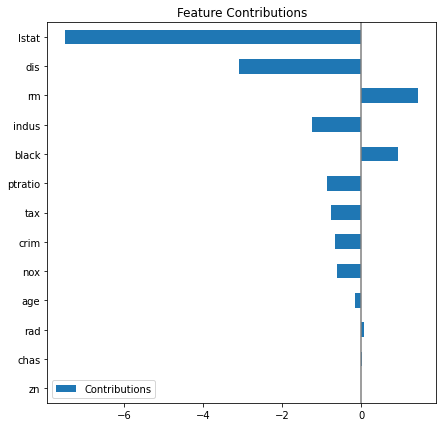

In [24]:
final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# Random Forest Classification 
- The example below is using **prima india diabetes dataset** for preciting the **diabetes outcome** for patient.
- The example is stricitly used for **demonstrating** the uagae of `GLMExplainTransformer`.


In [25]:
prima_indian_diabetes_csv = '/work/tests/data/classification/dataset_prima_indian_diabetes.csv'
prima_indian_diabetes_df = spark.read.option("header", True).option("inferSchema", True).csv(
    prima_indian_diabetes_csv)

In [26]:
label_column = 'outcome'
features_column = f"features_{label_column}"
prediction_column = f"prediction_{label_column}"

contrib_column = f"prediction_{label_column}_contrib"
contrib_column_sum = f"{contrib_column}_sum"
contrib_column_intercept = f"{contrib_column}_intercept"

features_importance_view = f"features_importance_{label_column}_view"
predictions_view = f"predictions_{label_column}_view"

In [27]:
categorical_columns=[]
continuous_columns = [x for x in prima_indian_diabetes_df.columns if x not in ['id', label_column]]

In [28]:
stages = get_ensemble_pipeline_stages([], continuous_columns + categorical_columns, label_column, ensemble_type="rf",classification=True)

In [29]:
import uuid
pipeline = Pipeline(stages=stages)
pipeline_model: PipelineModel = pipeline.fit(prima_indian_diabetes_df)
rf_model = pipeline_model.stages[-1]
string_id = uuid.uuid4()
rf_model_path: str = f"/tmp/{string_id}"
rf_model.write().save(rf_model_path)

In [30]:
prediction_df = pipeline_model.transform(prima_indian_diabetes_df)
prediction_df.createOrReplaceTempView(predictions_view)

In [31]:
features_importance_df = get_feature_importance(spark, rf_model, prediction_df, features_column)
features_importance_df.createOrReplaceTempView(features_importance_view)

In [32]:
explain_stages = get_ensemble_explain_stages(predictions_view, features_importance_view, label_column, rf_model_path,ensemble_type="rf",classification=True)
explain_pipeline = Pipeline(stages=explain_stages)
explain_df = explain_pipeline.fit(prediction_df).transform(prediction_df)

In [33]:
feature_index_meta = features_importance_df.select("Feature_Index", "Feature").orderBy("Feature_Index").rdd.collectAsMap()

In [34]:
expressions = []
for key,value in feature_index_meta.items():
    expressions.append(f"AVG({contrib_column}[{key}]) as {value}")

contributions = explain_df.selectExpr(expressions).collect()[0].asDict()

In [35]:
plot_contrib_df = pd.DataFrame.from_dict(contributions,orient='index',columns=['Contributions'])
plot_contrib_df.head()

,Contributions
pregnancies,0.018229
glucose,0.000000
blood_pressure,-0.049479
skin_thickness,0.023438
insulin,-0.032552


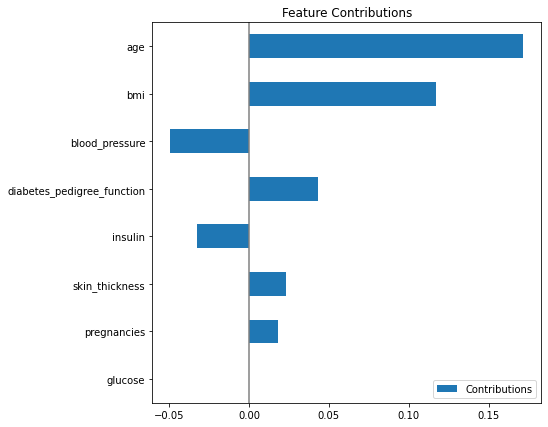

In [36]:
final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)